# Using the kMeans algorithm for the clustering of 2D blobs - A simple example

*Costas Andreopoulos \<c.andreopoulos@cern.ch\>*

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

**Generate and plot synthetic data**

In [2]:
n_samples = 300
n_features = 2
n_true_clusters = 5
random_state = 42

X, Y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_true_clusters, random_state=random_state)

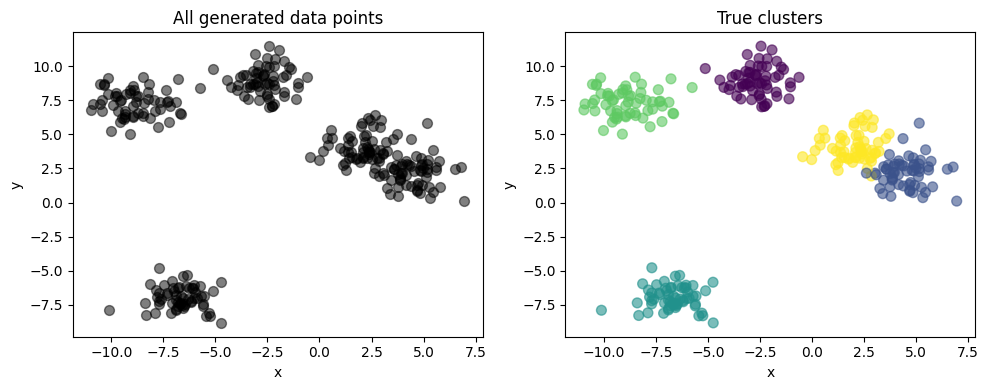

In [3]:
fig = plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(1,2,width_ratios=[1,1])
axL = fig.add_subplot(gs[0,0])
axL.scatter(X[:, 0], X[:, 1], color='black', s=50, alpha=0.5)
axL.set_title('All generated data points')
axL.set_xlabel("x")
axL.set_ylabel("y")
axR = fig.add_subplot(gs[0,1])
axR.scatter(X[:, 0], X[:, 1], c=Y, cmap='viridis', s=50, alpha=0.6)
axR.set_title('True clusters')
axR.set_xlabel("x")
axR.set_ylabel("y")
plt.tight_layout()
plt.show()

**Finding the optimal number of clusters**

The number of clusters to be formed, which is often unknown, is an input to the k-Means algorithm.

Use the **Elbow method** to determine the number of clusters.

The Elbow method is a common **heuristic**: It involves running the k-Means algorithm with different input number of clusters, and looking for the point where **inertia** (i.e. the Within-Cluster Sum of Squares (WCSS)) starts to flatten out. After this point, increasing the number of clusters has diminished returns and it is not worth the additional cost.

Related to inertia is the **explained variance**: It quantifies how well the clustering captures the total variance of the data. 
The explained variance ratio is given by 1 - inertia / total variance.

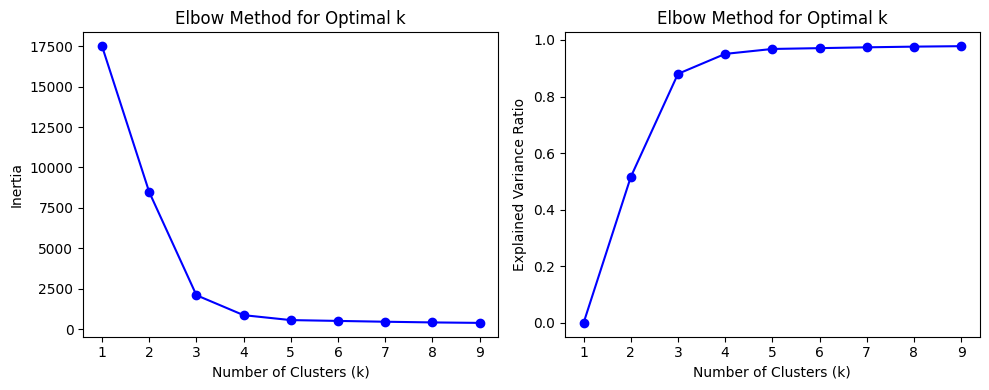

In [4]:
cluster_range = range(1, 2*n_true_clusters)
inertia_values = []
explained_variance_ratio = []

global_mean = np.mean(X, axis=0) # calculate mean for each feature (axis=0 operates down each column)
total_variance = np.sum((X-global_mean)**2)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)
    explained_variance_ratio.append(1.-kmeans.inertia_/total_variance)

# Plot the inertia and explained variance ratio as a function of the number of clusters
fig = plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(1,2,width_ratios=[1,1])
axL = fig.add_subplot(gs[0,0])
axL.plot(cluster_range, inertia_values, marker='o', linestyle='-', color='b')
axL.set_xlabel('Number of Clusters (k)')
axL.set_ylabel('Inertia')
axL.set_title('Elbow Method for Optimal k')
axL.set_xticks(cluster_range)
axR = fig.add_subplot(gs[0,1])
axR.plot(cluster_range, explained_variance_ratio, marker='o', linestyle='-', color='b')
axR.set_xlabel('Number of Clusters (k)')
axR.set_ylabel('Explained Variance Ratio')
axR.set_title('Elbow Method for Optimal k')
axR.set_xticks(cluster_range)
plt.tight_layout()
plt.show()

**Running kMeans for the optimal number of clusters**

In [5]:
# Looking at the above plot, select the point (number of clusters) where 
# diminished returns no longer worth the cost of adding a new cluster.
n_clusters_optimal = 5

# Apply K-Means clustering
kmeans = KMeans(n_clusters=n_clusters_optimal, random_state=random_state, n_init=10)
Y_kmeans = kmeans.fit_predict(X)

print(f"KMeans converged in {kmeans.n_iter_} iterations")

KMeans converged in 4 iterations


**Visualize the kMeans clusters**

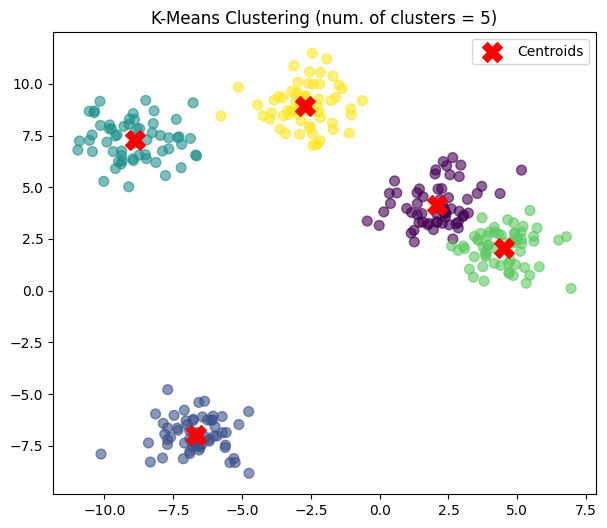

In [6]:
# Visualize the clustering
plt.figure(figsize=(7,6))
plt.scatter(X[:, 0], X[:, 1], c=Y_kmeans, cmap='viridis', s=50, alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='X', label='Centroids')
plt.title(f"K-Means Clustering (num. of clusters = {n_clusters_optimal})")
plt.legend()
plt.show()

The **silhouette score** for the data point $i$ is given by

$\displaystyle S{i} = \frac{b(i)-a(i)}{max\{b(i),a(i)\}}$

where $a(i)$ is the average distance between the point $i$ and all other points in its cluster, whereas $b(i)$ is the average distance between i and all points in the nearest cluster.

Average silhouette score for k-Means clustering: 0.66


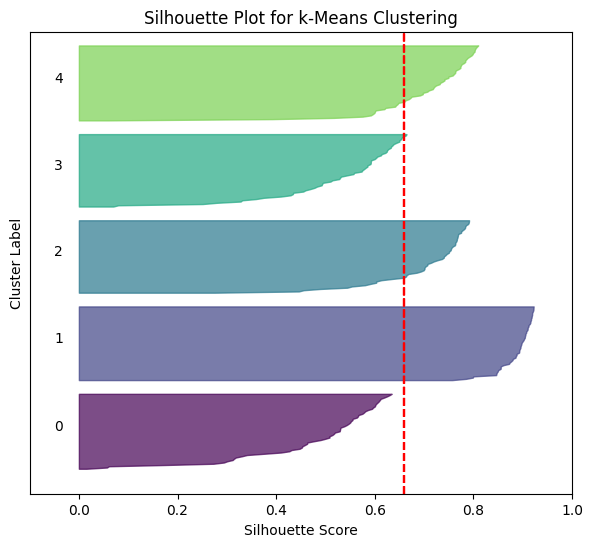

In [7]:
def plot_silhouette_score(X, Y_cluster, n_clusters, cluster_algo_label, ax):
    """
    Plot the silhouette score for every data point. Sort the points according to the score and group in assigned clusters.
    Compare with the average silhouette score.
    """
    # Compute the average silhouette score
    slsc_av = silhouette_score(X, Y_cluster)
    print(f"Average silhouette score for {cluster_algo_label} clustering: {slsc_av:.2f}")
    
    # Get the silhouette score for each point
    slsc = silhouette_samples(X, Y_cluster)

    y_lower =  0 
    y_upper = 10 
    for i in range(n_clusters):
        # Get the sillhouete scores for all points in current cluster and sort them
        slsc_cl = slsc[Y_cluster == i]
        slsc_cl.sort()    
        # Color a band between x = 0 and x = silhouette score, for each data point in the current cluster
        y_lower = y_upper + 10
        y_upper = y_lower + len(slsc_cl)    
        color = cm.viridis(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, slsc_cl, facecolor=color, edgecolor=color, alpha=0.7)    
        ax.text(-0.05, y_lower + 0.5 * len(slsc_cl), str(i))    

        # Add a line showing the average silhouette score 
        ax.axvline(slsc_av, color="red", linestyle="--")

        ax.set_xlabel("Silhouette Score")
        ax.set_ylabel("Cluster Label")
        ax.set_title(f"Silhouette Plot for {cluster_algo_label} Clustering")
        ax.set_xlim([-0.1, 1])
        ax.set_ylim([0, len(X) + (n_clusters + 2) * 10])
        ax.set_yticks([])
        
fig, ax = plt.subplots(figsize=(7,6))
plot_silhouette_score(X, Y_kmeans, n_clusters_optimal, "k-Means", ax)